# Analysis of DNA-MERFISH for CTP11

by Pu Zheng

2021.12.10

analysis for dataset:

\\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216

This data is DNA of smFISH RNA:
    \\10.245.74.158\Chromatin_NAS_6\20211216-P_brain_CTP12-RNA



In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

creating new log file
2022-01-07 13:39:19,427 [INFO] WRITING LOG OUTPUT TO C:\Users\puzheng\.cellpose\run.log
15516


# 0. fov parameters

In [2]:
dna_fov_param = {'data_folder':[r'\\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216',
                            r'\\10.245.74.158\Chromatin_NAS_6\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216',],
             'save_folder':r'M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216',
             'experiment_type': 'DNA',
             'num_threads': 16,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50',
             'shared_parameters':{
                     'single_im_size':[50,2048,2048],
                     'distance_zxy': [250, 108, 108],
                     'corr_channels':['750','647'],
                     'num_empty_frames': 0, 
                     'num_buffer_frames':0,
                     'corr_hot_pixel':True,
                     'corr_Z_shift':True,
                     'corr_bleed':True,
                     'min_num_seeds':10,
                     'max_num_seeds': None,
                     'spot_seeding_th': 2500,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                     'corr_gaussian_highpass':True
                 }, 
             }

rna_fov_param = {
    'data_folder':r'\\10.245.74.158\Chromatin_NAS_6\20211216-P_brain_CTP12-RNA',
    #'save_folder':r'\\crick\Shiwei_Crick_4\Analyzed_Data\20211216-P_brain_CTP12-RNA',
    'save_folder': r'P:\Analyzed_Data\20211216-P_brain_CTP12-RNA',
    'experiment_type': 'RNA',
    'num_threads': 16,
    'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50',
    'shared_parameters':{
        'single_im_size':[50,2048,2048],
        'distance_zxy': [250, 108, 108],
        'corr_channels':['750','647'],
        'num_empty_frames': 0, 
        'num_buffer_frames':0,
        'corr_hot_pixel':True,
        'corr_Z_shift':True,
        'corr_bleed':True,
        'min_num_seeds':100,
        'max_num_seeds': None,
        'spot_seeding_th': 1500,
        'normalize_intensity_local':False,
        'normalize_intensity_background':False,
        'corr_gaussian_highpass':True,
        }, 
    }

## Load rotation alignment

In [3]:
reload(ia.correction_tools.alignment)
rna_align_file = r'\\10.245.74.158\Chromatin_NAS_6\20211216-P_brain_CTP12-RNA\Experiments\10x_positions_before.txt'
dna_align_file = r'\\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Alignments\10x_positions_after.txt'
print(os.path.exists(rna_align_file), os.path.exists(dna_align_file))

R, t = ia.correction_tools.alignment.align_manual_points(rna_align_file, dna_align_file,
                                                         save_folder=None)

True True
- Manually picked points aligned, rotation:
[[ 0.99987138  0.01603818]
 [-0.01603818  0.99987138]],
 translation:[-2132.35179369 -1145.97222401]
-- rotation matrix saved to file:\\10.245.74.158\Chromatin_NAS_6\20211216-P_brain_CTP12-RNA\Experiments\rotation
-- translation matrix saved to file:\\10.245.74.158\Chromatin_NAS_6\20211216-P_brain_CTP12-RNA\Experiments\translation


# Batch

In [31]:
import math
_dz,_dx,_dy = np.shape(seg_labels)
_rotation_angle = np.arcsin(R[0,1])/math.pi*180
_rotation_M = cv2.getRotationMatrix2D((_dx/2, _dy/2), _rotation_angle, 1)

In [58]:
rot_labels = np.array([cv2.warpAffine(_seg_layer, _rotation_M, _seg_layer.shape, flags=cv2.INTER_NEAREST,
                                              borderMode=cv2.BORDER_CONSTANT) for _seg_layer in seg_labels])

In [77]:
reload(ia.segmentation_tools.cell)
reload(ia.correction_tools.translate)

new_label = segmentation_tools.cell.translate_segmentation(rna_fov.dapi_im, dna_fov.dapi_im,
                                               R,  seg_labels)

-- start calculating drift with rotation between images
-- aligning image -> directly use image
-- directly use ref_image
--- drift: [4.61 0.29 2.45] pixels


In [78]:
new_label.shape

(50, 2048, 2048)

In [75]:
reload(ia.segmentation_tools.cell)
reload(ia.correction_tools.translate)


<module 'ImageAnalysis3.correction_tools.translate' from '..\\..\\..\\..\\Documents\\ImageAnalysis3\\correction_tools\\translate.py'>

In [ ]:
#reload(ia.meta_tools.partition_spots)
from ImageAnalysis3.meta_tools.partition_spots import Spots_Partition
from ImageAnalysis3.classes.preprocess import Spots3D
dapi_th = 10000

cand_spot_folder = os.path.join(dna_fov_param['save_folder'], 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(cand_spot_folder)

sel_fov_ids = np.arange(25,120)
    
for _fov_id in sel_fov_ids:

    dna_fov = classes.field_of_view.Field_of_View(dna_fov_param, _fov_id=_fov_id,
                                                  _color_info_kwargs={
                                                      '_color_filename':'Color_Usage',
                                                  }, 
                                                  _prioritize_saved_attrs=False,
                                                  _save_info_to_file=False,
                                                  )

    # create rna_fov class
    rna_fov = classes.field_of_view.Field_of_View(rna_fov_param, _fov_id=_fov_id,
                                              _color_info_kwargs={
                                                  '_color_filename':'Color_Usage',
                                              }, 
                                              _prioritize_saved_attrs=False,
                                              _save_info_to_file=False,
                                              )
    
    # Load DAPI
    dna_dapi_im = dna_fov._load_dapi_image()
    rna_dapi_im = rna_fov._load_dapi_image()
    
    # align dapi images
    segmentation_filename = os.path.join(rna_fov.save_folder, 'Segmentation', 
                                     os.path.basename(dna_fov.save_filename).replace('.hdf5', '_Segmentation.npy'))
    seg_labels = np.load(segmentation_filename)

    new_label = segmentation_tools.cell.translate_segmentation(rna_fov.dapi_im, dna_fov.dapi_im,
                                                   R,  seg_labels)
    
    
    # partition spots into cells
    dna_fov._load_from_file('combo')

    pixel_sizes = dna_fov.shared_parameters['distance_zxy']
    single_im_size = dna_fov.shared_parameters['single_im_size']

    all_spots_list = [Spots3D(_spots, bits=_id, pixel_sizes=pixel_sizes) for _spots, _id in zip(dna_fov.combo_spots_list, dna_fov.combo_ids)]

    sp = Spots_Partition(new_label, "", 
                         search_radius=10, pixel_sizes=pixel_sizes,
                         save_filename=None)

    cell_2_spots = {_c:{} for _c in np.unique(new_label)[np.unique(new_label)>0]}

    for _spots, _id in zip(all_spots_list, dna_fov.combo_ids):
        _labels = sp.spots_to_labels(sp.segmentation_masks, _spots, sp.image_size)

        _signals = sp.spots_to_DAPI(dna_fov.dapi_im, _spots, single_im_size, search_radius=5)

        for _l in np.unique(_labels):
            if _l > 0:
                cell_2_spots[_l][_id] = _spots[(_labels==_l) * (_signals > dapi_th)]
                cell_2_spots[_l][_id].bits = _spots.bits[(_labels==_l) * (_signals > dapi_th)]
    # save spots
    for _cell_id, _spots_list in cell_2_spots.items():
        _cand_filename = os.path.join(cand_spot_folder, os.path.basename(dna_fov.save_filename).replace('.hdf5', f'_Cell-{_cell_id}_CandSpots.pkl') )
        print(_cand_filename)
        pickle.dump(_spots_list, open(_cand_filename, 'wb'))

M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 34
- Number of field of views: 211
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H5

- partition barcodes for 8836 spots
- calculate local DAPI signal for 8836 spots
- partition barcodes for 6633 spots
- calculate local DAPI signal for 6633 spots
- partition barcodes for 9064 spots
- calculate local DAPI signal for 9064 spots
- partition barcodes for 5391 spots
- calculate local DAPI signal for 5391 spots
- partition barcodes for 9102 spots
- calculate local DAPI signal for 9102 spots
- partition barcodes for 5395 spots
- calculate local DAPI signal for 5395 spots
- partition barcodes for 9076 spots
- calculate local DAPI signal for 9076 spots
- partition barcodes for 6196 spots
- calculate local DAPI signal for 6196 spots
- partition barcodes for 9492 spots
- calculate local DAPI signal for 9492 spots
- partition barcodes for 6281 spots
- calculate local DAPI signal for 6281 spots
- partition barcodes for 8980 spots
- calculate local DAPI signal for 8980 spots
- partition barcodes for 6827 spots
- calculate local DAPI signal for 6827 spots
- partition barcodes for 975

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 30
- Number of field of views: 211
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C26', 'H26C27', 'H27C28', 'H28C29', 'H29C30', 'H30C31', 'H31C32', 'H32C33', 'H33C34', 'H34C35', 'H35C36', 'H36C37', 'H37C38', 'H38C39', 'H39C40', 'H40C41', 'H41C42', 'H42C43', 'H43C44', 'H44C45', 'H45C46', 'H46C47', 'H47C48', 'H48C49', 'H49C50', 'H50U1', 'H51U2', 'H52U3', 'H53U4', 'H54U5', 'H55U6', 'H56U7', 'H57U8', 'H58U9', 'H59U10', 'H60U11', 'H61U12', 'H62U13', 'H63U14'])
- 64 folders are found according to color-usage annotation.
+ loading fov_info f

In [74]:
sp.segmentation_masks.shape

(2, 50, 2048, 2048)

In [69]:
sp = Spots_Partition(new_label, "", 
                     search_radius=10, pixel_sizes=pixel_sizes,
                     save_filename=None)

- Partition spots


In [70]:
for _spots, _id in zip(all_spots_list, dna_fov.combo_ids):
    _labels = sp.spots_to_labels(sp.segmentation_masks, _spots, sp.image_size)

    _signals = sp.spots_to_DAPI(dna_fov.dapi_im, _spots, single_im_size, search_radius=5)
    break
    for _l in np.unique(_labels):
        if _l > 0:
            cell_2_spots[_l][_id] = _spots[(_labels==_l) * (_signals > dapi_th)]
            cell_2_spots[_l][_id].bits = _spots.bits[(_labels==_l) * (_signals > dapi_th)]

- partition barcodes for 19314 spots
- calculate local DAPI signal for 19314 spots


<IPython.core.display.Javascript object>


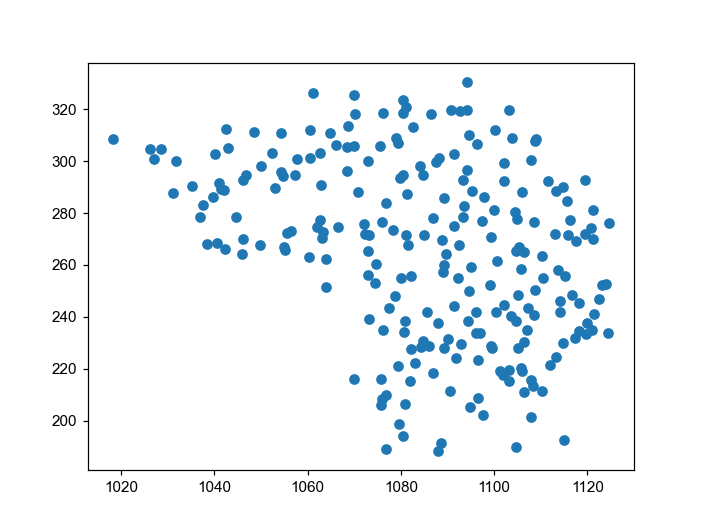

In [71]:
_sel_spots = _spots[_labels==4]

plt.figure()
plt.scatter(_sel_spots[:,3], _sel_spots[:,2])
plt.show()

## Create fov_class

In [ ]:
_fov_id = 10

dna_fov = classes.field_of_view.Field_of_View(dna_fov_param, _fov_id=_fov_id,
                                              _color_info_kwargs={
                                                  '_color_filename':'Color_Usage',
                                              }, 
                                              _prioritize_saved_attrs=False,
                                              _save_info_to_file=False,
                                              )

# create rna_fov class
rna_fov = classes.field_of_view.Field_of_View(rna_fov_param, _fov_id=_fov_id,
                                          _color_info_kwargs={
                                              '_color_filename':'Color_Usage',
                                          }, 
                                          _prioritize_saved_attrs=False,
                                          _save_info_to_file=False,
                                          )

## load dapi images

In [32]:

dna_dapi_im = dna_fov._load_dapi_image()

rna_dapi_im = rna_fov._load_dapi_image()

-- choose dapi images from folder: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\H0C1.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\H0C1\Conv_zscan_010.dax
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_4\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\H0C1\Conv_zscan_010.dax [3]
[3]
 in 4.998s
-- removing hot pixels for channels:['405'] in 7.161s
-- correct Z-shifts for channels:['405'] in 5.754s
-- illumination correction for channels: 405, in 2.215s
-- warp image with drift:[0. 0. 0.] in 0.000s
-- finish correction in 20.830s
-- saving fov_info to file: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\Conv_zscan_010.hdf5
++ base attributes saved:['dapi_im'] in 6.422s.


## Translate segmentation

In [99]:
segmentation_filename = os.path.join(rna_fov.save_folder, 'Segmentation', 
                                     os.path.basename(dna_fov.save_filename).replace('.hdf5', '_Segmentation.npy'))
seg_labels = np.load(segmentation_filename)


new_label = segmentation_tools.cell.translate_segmentation(rna_fov.dapi_im, dna_fov.dapi_im,
                                               R,  seg_labels)

-- start calculating drift with rotation between images
-- aligning image -> directly use image
-- directly use ref_image
--- drift: [ 0.06 -3.79 24.95] pixels


## Partition spots into cells

In [151]:
reload(ia.meta_tools.partition_spots)
from ImageAnalysis3.meta_tools.partition_spots import Spots_Partition
from ImageAnalysis3.classes.preprocess import Spots3D

dna_fov._load_from_file('combo')

pixel_sizes = dna_fov.shared_parameters['distance_zxy']
single_im_size = dna_fov.shared_parameters['single_im_size']

all_spots_list = [Spots3D(_spots, bits=_id, pixel_sizes=pixel_sizes) for _spots, _id in zip(dna_fov.combo_spots_list, dna_fov.combo_ids)]

dapi_th = 10000
sp = Spots_Partition(new_label, "", 
                     search_radius=10, pixel_sizes=pixel_sizes,
                     save_filename=None)


cell_2_spots = {_c:{} for _c in np.unique(new_label)[np.unique(new_label)>0]}

for _spots, _id in zip(all_spots_list, dna_fov.combo_ids):
    _labels = sp.spots_to_labels(sp.segmentation_masks, _spots, sp.image_size)

    _signals = sp.spots_to_DAPI(dna_fov.dapi_im, _spots, single_im_size, search_radius=5)

    for _l in np.unique(_labels):
        if _l > 0:
            cell_2_spots[_l][_id] = _spots[(_labels==_l) * (_signals > dapi_th)]
            cell_2_spots[_l][_id].bits = _spots.bits[(_labels==_l) * (_signals > dapi_th)]

- Partition spots
- partition barcodes for 4819 spots
- calculate local DAPI signal for 4819 spots
- partition barcodes for 8507 spots
- calculate local DAPI signal for 8507 spots
- partition barcodes for 4593 spots
- calculate local DAPI signal for 4593 spots


C:\Users\puzheng\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\puzheng\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- partition barcodes for 9160 spots
- calculate local DAPI signal for 9160 spots
- partition barcodes for 5602 spots
- calculate local DAPI signal for 5602 spots
- partition barcodes for 8292 spots
- calculate local DAPI signal for 8292 spots
- partition barcodes for 4812 spots
- calculate local DAPI signal for 4812 spots
- partition barcodes for 7774 spots
- calculate local DAPI signal for 7774 spots
- partition barcodes for 4451 spots
- calculate local DAPI signal for 4451 spots
- partition barcodes for 9039 spots
- calculate local DAPI signal for 9039 spots
- partition barcodes for 4617 spots
- calculate local DAPI signal for 4617 spots
- partition barcodes for 8911 spots
- calculate local DAPI signal for 8911 spots
- partition barcodes for 5017 spots
- calculate local DAPI signal for 5017 spots
- partition barcodes for 8894 spots
- calculate local DAPI signal for 8894 spots
- partition barcodes for 4524 spots
- calculate local DAPI signal for 4524 spots
- partition barcodes for 813

## Save

In [140]:
cand_spot_folder = os.path.join(dna_fov.save_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(cand_spot_folder)
    
    
# save spots
for _cell_id, _spots_list in cell_2_spots.items():
    _cand_filename = os.path.join(cand_spot_folder, os.path.basename(dna_fov.save_filename).replace('.hdf5', f'_Cell-{_cell_id}_CandSpots.pkl') )
    print(_cand_filename)
    pickle.dump(_spots_list, open(_cand_filename, 'wb'))

Creating cand_spot_folder: M:\Pu_Temp\20211220-P_brain_CTP11-1000_CTP12-DNA_from_1216\CandSpots
